This notebook contains all the code required to do the text analysis on the tweets. Essentially, I check to see if the words MPs use in their tweets is correlated to their chowkidar score. I find that it is, meaning that we can determine an MPs ideology from what they say, or that what they say is reflective of their ideology. This would mean that we can use Twitter/online presence as a new measure for ideology.

Some of the code here (the training and classification) takes an extremely long time to run. I have transformed data into datasets and back to try and cut time where possible, but if the training takes over 2 hours to run, that's normal.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random

In [2]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
matplotlib.rcParams['errorbar.capsize'] = 5
params = {'legend.fontsize': 'x-large',
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
matplotlib.rcParams.update(params)
# plt.rc('text', usetex=True)\n",
plt.rc('font', family='serif')

`mp_tweets.csv` contains the handle, party name, and tweet for all 167 MPs I was able to pull data for.

In [3]:
tweets_df = pd.read_csv('../Data/mp_tweets.csv')
tweets_df.head()

,handle,party_name,tweet
0,RaoKavitha,TRS,will take this issue to honourable KCR gari no...
1,RaoKavitha,TRS,ఎటువంటి జన్మ వచ్చినా.. ఎల్లప్పుడూ\nఆ శివుడి పా...
2,RaoKavitha,TRS,RT @DrGattu: @RaoKavitha @TelanganaCMO @trshar...
3,RaoKavitha,TRS,నరత్వం దేవత్వం నగవనమృగత్వం మశకత \nపశుత్వం కీటత...
4,RaoKavitha,TRS,https://t.co/q1dmCUGq3E


In [4]:
# Here you can see how some tweets are truncated and in the process of data collection, the remainder of the tweet
# was stored in a link that we will however not be able to use for the analysis.
tweets_df['tweet']

0         will take this issue to honourable KCR gari no...
1         ఎటువంటి జన్మ వచ్చినా.. ఎల్లప్పుడూ\nఆ శివుడి పా...
2         RT @DrGattu: @RaoKavitha @TelanganaCMO @trshar...
3         నరత్వం దేవత్వం నగవనమృగత్వం మశకత \nపశుత్వం కీటత...
4                                   https://t.co/q1dmCUGq3E
                                ...                        
388624    @narendramodi @BJP4India @BJP4Bengal https://t...
388625    @narendramodi @BJP4India @BJP4Bengal https://t...
388626    @narendramodi @BJP4India @BJP4Bengal https://t...
388627    @PMOIndia @BJP4India @BJP4Bengal https://t.co/...
388628    @PMOIndia @BJP4India @BJP4Bengal https://t.co/...
Name: tweet, Length: 388629, dtype: object

In [5]:
import re
split_pattern = re.compile('[ \n.,:;!?"\'/%&^…()\[\]]+')

In [7]:
# Read the stopwords.
with open('../Data/englishST.txt') as f:
    english_stopwords = f.read().split()
with open('../Data/hindiST.txt') as f:
    hindi_stopwords = f.read().split()
stopwords = set(['RT', 'http', 'https'] + english_stopwords + hindi_stopwords)

In [8]:
# Defining a function to split a tweet into words.
def split_tweet_into_words(tweet):
    words = re.split(split_pattern, tweet)
    composite_list = [w.split() for w in words]
    words = [w.lower() for sublist in composite_list for w in sublist]
    words = [w for w in words if not w[0] == '@'] # Remove mentions
    return [w for w in words if w not in stopwords]

In [9]:
# For dictionaries and topic modeling.
from gensim import corpora, models, similarities
from gensim.corpora import Dictionary

In [10]:
class PandasCorpus(object):
        
    def __init__(self, dataframe, stopwords=[]):
        self.dataframe = dataframe
        self.stopwords = stopwords
        
    def __iter__(self):
        """This returns every document, one at a time."""
        for idx, row in self.dataframe.iterrows():
            yield split_tweet_into_words(row['tweet'])
        

In [11]:
tweet_corpus = PandasCorpus(tweets_df)

In [12]:
dictionary = corpora.Dictionary(tweet_corpus)

In [13]:
for x in tweet_corpus:
    print(x)
    break

['issue', 'honourable', 'kcr', 'gari', 'notice', 'stop', 'protest', 'appeal', 'pharma', 'students', 'jrlgnih3nq']


In [14]:
dictionary.filter_extremes(no_below=5, no_above=0.5)

In [15]:
len(dictionary)

52623

In [16]:
proc_corpus = [dictionary.doc2bow(doc) for doc in tweet_corpus]
tfidf_model = models.TfidfModel(proc_corpus)

# Training Framework

In [17]:
import torch

In [18]:
# I need a function that turns a tweet into a tensor.
def tweet2tensor(tweet):
    words = split_tweet_into_words(tweet)
    v_sparse = dictionary.doc2bow(words) # tfidf_model[dictionary.doc2bow(words)]
    t = torch.zeros(len(dictionary))
    for i, x in v_sparse:
        t[i] = x
    return t

In [19]:
tweet2tensor("I take this issue to heart")

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [20]:
# For the training, we need to create a dataset.
from torch.utils.data import Dataset
import torch

class TwitterDataset(Dataset):
    
    def __init__(self, dataframe, target_function=None):
        """The target_function must take a row of the dataframe, and return 
        a learning target."""
        self.dataframe = dataframe
        self.target_function = target_function
        
    def __len__(self):
        return len(self.dataframe)
        
    def __getitem__(self, idx):
        r = self.dataframe.loc[idx]
        tweet = r['tweet']
        t = tweet2tensor(tweet)
        if self.target_function is None:
            return t
        else:
            target = torch.tensor([float(self.target_function(r))])
            return t, target


In [21]:
chowkidar_proportions = pd.read_csv('../Results/chowkidar_proportions.csv').drop(['Unnamed: 0'], axis=1)
chowkidar_proportions.head()

,source,chowkidar yes/no mean
0,mphemantgodse,0.0
1,salimdotcomrade,0.0
2,ET_MohdBasheer,0.0
3,RavneetBittu,0.0
4,MausamNoor,0.0


In [22]:
tweets_with_proportions = pd.merge(left=tweets_df, right=chowkidar_proportions,
                                   left_on='handle', right_on='source').drop(['source'], axis=1)
tweets_with_proportions.head()

,handle,party_name,tweet,chowkidar yes/no mean
0,RaoKavitha,TRS,will take this issue to honourable KCR gari no...,0.013889
1,RaoKavitha,TRS,ఎటువంటి జన్మ వచ్చినా.. ఎల్లప్పుడూ\nఆ శివుడి పా...,0.013889
2,RaoKavitha,TRS,RT @DrGattu: @RaoKavitha @TelanganaCMO @trshar...,0.013889
3,RaoKavitha,TRS,నరత్వం దేవత్వం నగవనమృగత్వం మశకత \nపశుత్వం కీటత...,0.013889
4,RaoKavitha,TRS,https://t.co/q1dmCUGq3E,0.013889


In [23]:
len(tweets_with_proportions.index)

385399

In [24]:
tweets_with_proportions['party_name'].unique()

array(['TRS', 'BJP', 'YSRCP', 'TDP', 'INC', 'LJP', 'BLSP', 'INLD',
       'JKPDP', 'SHS', 'NCP', 'BJD', 'SAD', 'AAAP', 'SDF', 'PMK', 'ADMK',
       'AD', 'AITC'], dtype=object)

#### CAUTION: 
1. `chowkidar_proportions` has 327 handles, `tweets_df` only has 167.
2. So when we merge the two to get the Chowkidar proportion attached to the tweets, we cut down the number of handles to 167.

I decide on a 120/47 train/test split, so I take a sample 120 of the unique handles in tweets_with_proportions and then pull tweets from those handles as my training set.

In [27]:
rhandle = np.random.choice(tweets_with_proportions['handle'].unique(), 120, replace=False)
train_df = tweets_with_proportions.loc[tweets_with_proportions['handle'].isin(rhandle)]
len(train_df['handle'].unique()), len(rhandle)

(120, 120)

In [28]:
train_df = train_df.reset_index().drop(['index'], axis=1)
train_df

,handle,party_name,tweet,chowkidar yes/no mean
0,RaoKavitha,TRS,will take this issue to honourable KCR gari no...,0.013889
1,RaoKavitha,TRS,ఎటువంటి జన్మ వచ్చినా.. ఎల్లప్పుడూ\nఆ శివుడి పా...,0.013889
2,RaoKavitha,TRS,RT @DrGattu: @RaoKavitha @TelanganaCMO @trshar...,0.013889
3,RaoKavitha,TRS,నరత్వం దేవత్వం నగవనమృగత్వం మశకత \nపశుత్వం కీటత...,0.013889
4,RaoKavitha,TRS,https://t.co/q1dmCUGq3E,0.013889
...,...,...,...,...
277535,SSAhluwaliaMP,BJP,Subject: Re: Must C SAI Sartaj -\nVery soul S...,0.307692
277536,SSAhluwaliaMP,BJP,हिन्दी कविताएँ अौर कहानियाँ http://t.co/RYMM...,0.307692
277537,SSAhluwaliaMP,BJP,Dooj is known as Gurta Gaddi divas also for Si...,0.307692
277538,SSAhluwaliaMP,BJP,"Cellphone towers damaging birds, bees: Report ...",0.307692


In [29]:
len(train_df)

277540

In [30]:
train_df['tweet'][1500]

'Attended for Ayyappa puja at Korutla on the occasion of vasanta panchami https://t.co/BYYA2X5Rpu'

In [31]:
# train_df.to_csv(r'../Results/train_tweets.csv')

# Defining the Net

In [32]:
# Now, let's build a neural net for recognizing the author. 
from torch.nn import Module
from torch import nn
import torch.nn.functional as F

class SimpleNet(Module):
    
    def __init__(self, num_inputs):
        super(SimpleNet, self).__init__()
        # Now we define the layers. 
        # A linear layer computes \sum_i w_ij x_j + b_i
        self.layer1 = nn.Linear(num_inputs, 1)
        
    def forward(self, x):
        # Apply the first layer, which is linear.
        x = self.layer1(x)
        # Then, applies a sigmoid function to translate [-infty +infty] to [0, 1]
        return torch.sigmoid(x)

In [33]:
# Training function.
from torch.utils.data import DataLoader
from torch import optim
from torch.nn import MSELoss
loss_fn = MSELoss()

def train(net, dataset, num_epochs=1, lr=1.0):
    # We need to define an optimizer, which is something that drives the learning.
    params = net.parameters() # These are the parameters that need tuning. 
    optimizer = optim.Adadelta(params, lr=lr) # This is the thing that tunes them.
    train_loader = DataLoader(dataset, shuffle=True, batch_size=100)
    for epoch_idx in range(num_epochs):
        print("------- Epoch: {} -------".format(epoch_idx + 1))
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad() # Forget old gradient. 
            output = net(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 10 == 0:
                print("batch: {} loss: {}".format(batch_idx, loss))
            

# Classification

In [34]:
# First, we train
net = SimpleNet(len(dictionary))

def target_function(row):
    return row['chowkidar yes/no mean']
    
training_dataset = TwitterDataset(train_df, target_function=target_function)

In [35]:
# Trying it out on the first handle in train_df

target_function(train_df.iloc[1500])

0.013888888888888888

In [35]:
len(train_df.index)

273136

In [36]:
training_dataset[1500]

(tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0.5079]))

In [37]:
train(net, training_dataset, num_epochs=2, lr=1.)

------- Epoch: 1 -------
batch: 0 loss: 0.056264203041791916
batch: 10 loss: 0.04566383361816406
batch: 20 loss: 0.046088751405477524
batch: 30 loss: 0.03017589822411537
batch: 40 loss: 0.037242185324430466
batch: 50 loss: 0.032350484281778336
batch: 60 loss: 0.03300950303673744
batch: 70 loss: 0.0270206481218338
batch: 80 loss: 0.022108305245637894
batch: 90 loss: 0.02374693937599659
batch: 100 loss: 0.0270045455545187
batch: 110 loss: 0.028975822031497955
batch: 120 loss: 0.028973808512091637
batch: 130 loss: 0.022320425137877464
batch: 140 loss: 0.018688920885324478
batch: 150 loss: 0.019501972943544388
batch: 160 loss: 0.02543499693274498
batch: 170 loss: 0.024617761373519897
batch: 180 loss: 0.021008791401982307
batch: 190 loss: 0.025364786386489868
batch: 200 loss: 0.02729552611708641
batch: 210 loss: 0.022872084751725197
batch: 220 loss: 0.025612277910113335
batch: 230 loss: 0.02410421147942543
batch: 240 loss: 0.02109389193356037
batch: 250 loss: 0.019705114886164665
batch: 260

batch: 2150 loss: 0.013790507800877094
batch: 2160 loss: 0.014517415314912796
batch: 2170 loss: 0.01387226115912199
batch: 2180 loss: 0.01825004816055298
batch: 2190 loss: 0.025204923003911972
batch: 2200 loss: 0.015199241228401661
batch: 2210 loss: 0.019699586555361748
batch: 2220 loss: 0.01975261978805065
batch: 2230 loss: 0.014911260455846786
batch: 2240 loss: 0.018519245088100433
batch: 2250 loss: 0.013703232631087303
batch: 2260 loss: 0.019980143755674362
batch: 2270 loss: 0.01982164941728115
batch: 2280 loss: 0.017456691712141037
batch: 2290 loss: 0.0157234538346529
batch: 2300 loss: 0.016792379319667816
batch: 2310 loss: 0.016849040985107422
batch: 2320 loss: 0.01642029732465744
batch: 2330 loss: 0.014428081922233105
batch: 2340 loss: 0.018535306677222252
batch: 2350 loss: 0.017910659313201904
batch: 2360 loss: 0.02007385343313217
batch: 2370 loss: 0.012912854552268982
batch: 2380 loss: 0.01925254426896572
batch: 2390 loss: 0.01721501722931862
batch: 2400 loss: 0.018219638615846

batch: 1550 loss: 0.018232643604278564
batch: 1560 loss: 0.018131161108613014
batch: 1570 loss: 0.015620464459061623
batch: 1580 loss: 0.020808430388569832
batch: 1590 loss: 0.018359452486038208
batch: 1600 loss: 0.01863120123744011
batch: 1610 loss: 0.0141286076977849
batch: 1620 loss: 0.014796321280300617
batch: 1630 loss: 0.013947018422186375
batch: 1640 loss: 0.01408083364367485
batch: 1650 loss: 0.016975998878479004
batch: 1660 loss: 0.018050042912364006
batch: 1670 loss: 0.0164007768034935
batch: 1680 loss: 0.02133498154580593
batch: 1690 loss: 0.017139311879873276
batch: 1700 loss: 0.017488954588770866
batch: 1710 loss: 0.017502447590231895
batch: 1720 loss: 0.01623603142797947
batch: 1730 loss: 0.01548338308930397
batch: 1740 loss: 0.01812134124338627
batch: 1750 loss: 0.017886711284518242
batch: 1760 loss: 0.01886448636651039
batch: 1770 loss: 0.02052503451704979
batch: 1780 loss: 0.0167836956679821
batch: 1790 loss: 0.022122766822576523
batch: 1800 loss: 0.019917631521821022


In [38]:
def classify_tweet(net, tweet):
    t = tweet2tensor(tweet)
    return net(t).item()

In [39]:
def classify_mp(net, handle):
    count = 0
    total = 0
    for _, row in tweets_df[tweets_df['handle'] == handle].iterrows():
        count += 1
        total += classify_tweet(net, row['tweet'])
#     print("On the basis of:", count, "tweets, we classify:", total / count)
    return total/count

In [40]:
train_df.head(1)

,handle,party_name,tweet,chowkidar yes/no mean
0,Dattatreya,BJP,RT @mygovindia: What are your ideas and sugges...,0.507853


In [41]:
classify_mp(net, 'myogiadityanath')

0.4412541805500555

In [42]:
tweets_with_proportions.loc[tweets_with_proportions['handle'] == 'myogiadityanath']['chowkidar yes/no mean'].iloc[0]

0.6818181818181818

In [43]:
# table that has all the MPs who weren't in the training set

train_mps = train_df['handle'].unique()
not_train = tweets_with_proportions.loc[~tweets_with_proportions['handle'].isin(train_mps)]
len(not_train['handle'].unique())

46

In [44]:
# Validate set.
rhandle2 = not_train['handle'].unique()

In [45]:
val = tweets_with_proportions.loc[tweets_with_proportions['handle'].isin(rhandle2)]
val.head(1)

,handle,party_name,tweet,chowkidar yes/no mean
0,RaoKavitha,TRS,will take this issue to honourable KCR gari no...,0.013889


In [46]:
# len(val['handle'].unique())
val_unique = val['handle'].unique()
classification = []
for mp in val_unique:
    classification.append([mp, classify_mp(net, mp)])

In [47]:
len(classification)

46

In [48]:
classification_df = pd.DataFrame(classification, columns=['handle', 'classification'])
classification_df.head()

,handle,classification
0,RaoKavitha,0.303758
1,KirenRijiju,0.319382
2,rgohainbjp,0.315090
3,sarbanandsonwal,0.319205
4,sanjayjaiswalMP,0.346772


In [49]:
val_classifications = pd.merge(left=val, right=classification_df,
                               left_on='handle', right_on='handle')
val_classifications.head()

,handle,party_name,tweet,chowkidar yes/no mean,classification
0,RaoKavitha,TRS,will take this issue to honourable KCR gari no...,0.013889,0.303758
1,RaoKavitha,TRS,ఎటువంటి జన్మ వచ్చినా.. ఎల్లప్పుడూ\nఆ శివుడి పా...,0.013889,0.303758
2,RaoKavitha,TRS,RT @DrGattu: @RaoKavitha @TelanganaCMO @trshar...,0.013889,0.303758
3,RaoKavitha,TRS,నరత్వం దేవత్వం నగవనమృగత్వం మశకత \nపశుత్వం కీటత...,0.013889,0.303758
4,RaoKavitha,TRS,https://t.co/q1dmCUGq3E,0.013889,0.303758


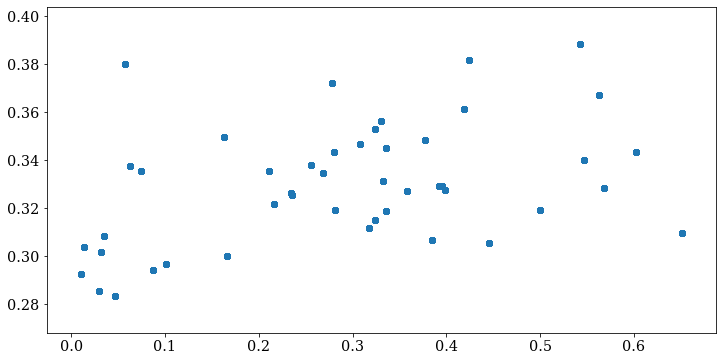

In [50]:
plt.scatter(val_classifications['chowkidar yes/no mean'], val_classifications['classification'])

In [51]:
a = np.corrcoef(val_classifications['chowkidar yes/no mean'], val_classifications['classification'])
a

array([[1.        , 0.45350997],
       [0.45350997, 1.        ]])

In [52]:
a[0].item(1)

0.4535099714715869

## Cross validation

In [53]:
# rotating through the training set 10 times.
# could technically do more but since there's only 167 MPs doesn't feel necessary.

corr_coefs = []
for i in np.arange(10):
    # rotate the training set
    random_h = np.random.choice(tweets_with_proportions['handle'].unique(), 120, replace=False)
    train_df = tweets_with_proportions.loc[tweets_with_proportions['handle'].isin(random_h)]
    train_df = train_df.reset_index().drop(['index'], axis=1)
    
    training_dataset = TwitterDataset(train_df, target_function=target_function)
    train(net, training_dataset, num_epochs=2, lr=1.)
    
    # test the training algorithm
    train_mps = train_df['handle'].unique()
    test_df = tweets_with_proportions.loc[~tweets_with_proportions['handle'].isin(train_mps)]
    test_unique = val['handle'].unique()
    classification = []
    for mp in test_unique:
        classification.append([mp, classify_mp(net, mp)])
    classification_df = pd.DataFrame(classification, columns=['handle', 'classification'])
    test_classifications = pd.merge(left=test_df, right=classification_df,
                                    left_on='handle', right_on='handle')
    
    # get the correlation
    corr_coef = np.corrcoef(test_classifications['chowkidar yes/no mean'], test_classifications['classification'])
    corr_coefs.append(corr_coef[0].item(1))
    
    # print message
    print('round ', i+1, 'done')

------- Epoch: 1 -------
batch: 0 loss: 0.025804921984672546
batch: 10 loss: 0.014599651098251343
batch: 20 loss: 0.019178014248609543
batch: 30 loss: 0.020770564675331116
batch: 40 loss: 0.02434237115085125
batch: 50 loss: 0.020733017474412918
batch: 60 loss: 0.024805206805467606
batch: 70 loss: 0.020691420882940292
batch: 80 loss: 0.02108277752995491
batch: 90 loss: 0.018613794818520546
batch: 100 loss: 0.018196359276771545
batch: 110 loss: 0.020450012758374214
batch: 120 loss: 0.019538378342986107
batch: 130 loss: 0.024294400587677956
batch: 140 loss: 0.01819685474038124
batch: 150 loss: 0.015197334811091423
batch: 160 loss: 0.02110593020915985
batch: 170 loss: 0.018247555941343307
batch: 180 loss: 0.0200913418084383
batch: 190 loss: 0.01995062828063965
batch: 200 loss: 0.01873810589313507
batch: 210 loss: 0.022458553314208984
batch: 220 loss: 0.01904839277267456
batch: 230 loss: 0.017793145030736923
batch: 240 loss: 0.019074570387601852
batch: 250 loss: 0.0223207026720047
batch: 26

batch: 2150 loss: 0.02062714286148548
batch: 2160 loss: 0.017144745215773582
batch: 2170 loss: 0.021336037665605545
batch: 2180 loss: 0.019026124849915504
batch: 2190 loss: 0.01902630180120468
batch: 2200 loss: 0.025691505521535873
batch: 2210 loss: 0.025636127218604088
batch: 2220 loss: 0.012323870323598385
batch: 2230 loss: 0.022095564752817154
batch: 2240 loss: 0.016900736838579178
batch: 2250 loss: 0.019161097705364227
batch: 2260 loss: 0.023974303156137466
batch: 2270 loss: 0.015478750690817833
batch: 2280 loss: 0.017383061349391937
batch: 2290 loss: 0.023297693580389023
batch: 2300 loss: 0.020034000277519226
batch: 2310 loss: 0.018703125417232513
batch: 2320 loss: 0.025641020387411118
batch: 2330 loss: 0.017390485852956772
batch: 2340 loss: 0.018997834995388985
batch: 2350 loss: 0.019531603902578354
batch: 2360 loss: 0.016995340585708618
batch: 2370 loss: 0.023542456328868866
batch: 2380 loss: 0.019034581258893013
batch: 2390 loss: 0.019356386736035347
batch: 2400 loss: 0.0231998

batch: 1610 loss: 0.02010808326303959
batch: 1620 loss: 0.021749062463641167
batch: 1630 loss: 0.01999962143599987
batch: 1640 loss: 0.023610655218362808
batch: 1650 loss: 0.01945221610367298
batch: 1660 loss: 0.021760011091828346
batch: 1670 loss: 0.01956399902701378
batch: 1680 loss: 0.020951135084033012
batch: 1690 loss: 0.01937592215836048
batch: 1700 loss: 0.02032287046313286
batch: 1710 loss: 0.0181594155728817
batch: 1720 loss: 0.017596200108528137
batch: 1730 loss: 0.02545509673655033
batch: 1740 loss: 0.02294924296438694
batch: 1750 loss: 0.019956538453698158
batch: 1760 loss: 0.02237355336546898
batch: 1770 loss: 0.021895918995141983
batch: 1780 loss: 0.02090413309633732
batch: 1790 loss: 0.020275134593248367
batch: 1800 loss: 0.020546386018395424
batch: 1810 loss: 0.01665913499891758
batch: 1820 loss: 0.019289953634142876
batch: 1830 loss: 0.016989855095744133
batch: 1840 loss: 0.021184498444199562
batch: 1850 loss: 0.019773172214627266
batch: 1860 loss: 0.019011007621884346

batch: 1070 loss: 0.017145223915576935
batch: 1080 loss: 0.020332111045718193
batch: 1090 loss: 0.014786915853619576
batch: 1100 loss: 0.01942404732108116
batch: 1110 loss: 0.018662037327885628
batch: 1120 loss: 0.022600334137678146
batch: 1130 loss: 0.020059388130903244
batch: 1140 loss: 0.016991976648569107
batch: 1150 loss: 0.020462380722165108
batch: 1160 loss: 0.014008656144142151
batch: 1170 loss: 0.01642315275967121
batch: 1180 loss: 0.01915500871837139
batch: 1190 loss: 0.015846028923988342
batch: 1200 loss: 0.018897661939263344
batch: 1210 loss: 0.015252306126058102
batch: 1220 loss: 0.019546713680028915
batch: 1230 loss: 0.017131343483924866
batch: 1240 loss: 0.016526244580745697
batch: 1250 loss: 0.022521253675222397
batch: 1260 loss: 0.017908576875925064
batch: 1270 loss: 0.01802179217338562
batch: 1280 loss: 0.01959466189146042
batch: 1290 loss: 0.0180820319801569
batch: 1300 loss: 0.01567254588007927
batch: 1310 loss: 0.01770060323178768
batch: 1320 loss: 0.01921050809323

batch: 440 loss: 0.01592327654361725
batch: 450 loss: 0.01757708005607128
batch: 460 loss: 0.019756032153964043
batch: 470 loss: 0.019672228023409843
batch: 480 loss: 0.017948783934116364
batch: 490 loss: 0.01724146492779255
batch: 500 loss: 0.01576320081949234
batch: 510 loss: 0.016779249534010887
batch: 520 loss: 0.018087081611156464
batch: 530 loss: 0.015200017020106316
batch: 540 loss: 0.015933049842715263
batch: 550 loss: 0.017530400305986404
batch: 560 loss: 0.01652413047850132
batch: 570 loss: 0.02186020463705063
batch: 580 loss: 0.014795409515500069
batch: 590 loss: 0.0175763126462698
batch: 600 loss: 0.015682488679885864
batch: 610 loss: 0.016776850447058678
batch: 620 loss: 0.016003785654902458
batch: 630 loss: 0.01613558642566204
batch: 640 loss: 0.0182010717689991
batch: 650 loss: 0.019280286505818367
batch: 660 loss: 0.015289416536688805
batch: 670 loss: 0.02005935087800026
batch: 680 loss: 0.01935667172074318
batch: 690 loss: 0.021159209311008453
batch: 700 loss: 0.018674

batch: 2580 loss: 0.018254749476909637
batch: 2590 loss: 0.015077812597155571
batch: 2600 loss: 0.015467316843569279
batch: 2610 loss: 0.011882137507200241
batch: 2620 loss: 0.018779931589961052
batch: 2630 loss: 0.0191311314702034
batch: 2640 loss: 0.0147934565320611
batch: 2650 loss: 0.018716242164373398
batch: 2660 loss: 0.012491540983319283
batch: 2670 loss: 0.01854288950562477
batch: 2680 loss: 0.01879606768488884
batch: 2690 loss: 0.01992887258529663
batch: 2700 loss: 0.015882615000009537
batch: 2710 loss: 0.019698401913046837
batch: 2720 loss: 0.016306845471262932
batch: 2730 loss: 0.01750841550529003
batch: 2740 loss: 0.015388958156108856
batch: 2750 loss: 0.017031053081154823
round  2 done
------- Epoch: 1 -------
batch: 0 loss: 0.015101263299584389
batch: 10 loss: 0.02087278664112091
batch: 20 loss: 0.021903060376644135
batch: 30 loss: 0.017892509698867798
batch: 40 loss: 0.01537500973790884
batch: 50 loss: 0.01641637645661831
batch: 60 loss: 0.01798035018146038
batch: 70 los

batch: 1960 loss: 0.01682252250611782
batch: 1970 loss: 0.014918377622961998
batch: 1980 loss: 0.016064681112766266
batch: 1990 loss: 0.01739136129617691
batch: 2000 loss: 0.014266843907535076
batch: 2010 loss: 0.019337136298418045
batch: 2020 loss: 0.019018882885575294
batch: 2030 loss: 0.017259398475289345
batch: 2040 loss: 0.015793833881616592
batch: 2050 loss: 0.016141613945364952
batch: 2060 loss: 0.012452165596187115
batch: 2070 loss: 0.02039564959704876
batch: 2080 loss: 0.015510890632867813
batch: 2090 loss: 0.019147809594869614
batch: 2100 loss: 0.019548678770661354
batch: 2110 loss: 0.0253601111471653
batch: 2120 loss: 0.014444450847804546
batch: 2130 loss: 0.01674608699977398
batch: 2140 loss: 0.015417368151247501
batch: 2150 loss: 0.01751714013516903
batch: 2160 loss: 0.013226785697042942
batch: 2170 loss: 0.015793459489941597
batch: 2180 loss: 0.014459781348705292
batch: 2190 loss: 0.013577939942479134
batch: 2200 loss: 0.014727155677974224
batch: 2210 loss: 0.016808239743

batch: 1390 loss: 0.017571603879332542
batch: 1400 loss: 0.016841718927025795
batch: 1410 loss: 0.016241589561104774
batch: 1420 loss: 0.020075645297765732
batch: 1430 loss: 0.01818140782415867
batch: 1440 loss: 0.011829646304249763
batch: 1450 loss: 0.017374230548739433
batch: 1460 loss: 0.019494513049721718
batch: 1470 loss: 0.017876453697681427
batch: 1480 loss: 0.01600029692053795
batch: 1490 loss: 0.017669502645730972
batch: 1500 loss: 0.02528572268784046
batch: 1510 loss: 0.017499370500445366
batch: 1520 loss: 0.017531825229525566
batch: 1530 loss: 0.016255196183919907
batch: 1540 loss: 0.014115847647190094
batch: 1550 loss: 0.01647789217531681
batch: 1560 loss: 0.024477550759911537
batch: 1570 loss: 0.02005132846534252
batch: 1580 loss: 0.014239552430808544
batch: 1590 loss: 0.015614726580679417
batch: 1600 loss: 0.011612317524850368
batch: 1610 loss: 0.0209124106913805
batch: 1620 loss: 0.02036447450518608
batch: 1630 loss: 0.01503723580390215
batch: 1640 loss: 0.01505640894174

batch: 820 loss: 0.016992684453725815
batch: 830 loss: 0.01715233363211155
batch: 840 loss: 0.016150636598467827
batch: 850 loss: 0.016339212656021118
batch: 860 loss: 0.015911966562271118
batch: 870 loss: 0.01967845857143402
batch: 880 loss: 0.01943111978471279
batch: 890 loss: 0.018566077575087547
batch: 900 loss: 0.01588633470237255
batch: 910 loss: 0.014294722117483616
batch: 920 loss: 0.012793821282684803
batch: 930 loss: 0.016120020300149918
batch: 940 loss: 0.015608785673975945
batch: 950 loss: 0.02170662395656109
batch: 960 loss: 0.01654261350631714
batch: 970 loss: 0.018971402198076248
batch: 980 loss: 0.01429937407374382
batch: 990 loss: 0.01839258149266243
batch: 1000 loss: 0.020229989662766457
batch: 1010 loss: 0.015242161229252815
batch: 1020 loss: 0.021832671016454697
batch: 1030 loss: 0.011717681773006916
batch: 1040 loss: 0.016345173120498657
batch: 1050 loss: 0.01976316049695015
batch: 1060 loss: 0.021090572699904442
batch: 1070 loss: 0.01805202290415764
batch: 1080 lo

batch: 70 loss: 0.01783163845539093
batch: 80 loss: 0.015502364374697208
batch: 90 loss: 0.014823411591351032
batch: 100 loss: 0.017955316230654716
batch: 110 loss: 0.01768435724079609
batch: 120 loss: 0.01685628853738308
batch: 130 loss: 0.014445237815380096
batch: 140 loss: 0.013643370941281319
batch: 150 loss: 0.023599298670887947
batch: 160 loss: 0.018828054890036583
batch: 170 loss: 0.017302436754107475
batch: 180 loss: 0.016616376116871834
batch: 190 loss: 0.016230463981628418
batch: 200 loss: 0.02160274237394333
batch: 210 loss: 0.016387971118092537
batch: 220 loss: 0.016761913895606995
batch: 230 loss: 0.018098365515470505
batch: 240 loss: 0.017979145050048828
batch: 250 loss: 0.019299643114209175
batch: 260 loss: 0.019049398601055145
batch: 270 loss: 0.01767234317958355
batch: 280 loss: 0.019052838906645775
batch: 290 loss: 0.01700916886329651
batch: 300 loss: 0.018525686115026474
batch: 310 loss: 0.01836835779249668
batch: 320 loss: 0.01702144555747509
batch: 330 loss: 0.0158

batch: 2210 loss: 0.015175368636846542
batch: 2220 loss: 0.014620134606957436
batch: 2230 loss: 0.01737799495458603
batch: 2240 loss: 0.02104843594133854
batch: 2250 loss: 0.016946010291576385
batch: 2260 loss: 0.015840735286474228
batch: 2270 loss: 0.017312828451395035
batch: 2280 loss: 0.012476161122322083
batch: 2290 loss: 0.013323957100510597
batch: 2300 loss: 0.015178431756794453
batch: 2310 loss: 0.013462268747389317
batch: 2320 loss: 0.016936374828219414
batch: 2330 loss: 0.018903467804193497
batch: 2340 loss: 0.017879266291856766
batch: 2350 loss: 0.01725940965116024
batch: 2360 loss: 0.01978001371026039
batch: 2370 loss: 0.014345118775963783
batch: 2380 loss: 0.015269451774656773
batch: 2390 loss: 0.013067460618913174
batch: 2400 loss: 0.01882164366543293
batch: 2410 loss: 0.019355088472366333
batch: 2420 loss: 0.01569724828004837
batch: 2430 loss: 0.017927544191479683
batch: 2440 loss: 0.016842644661664963
batch: 2450 loss: 0.013564600609242916
batch: 2460 loss: 0.02135870978

batch: 1480 loss: 0.01850772835314274
batch: 1490 loss: 0.015947513282299042
batch: 1500 loss: 0.019344042986631393
batch: 1510 loss: 0.017567699775099754
batch: 1520 loss: 0.01533532701432705
batch: 1530 loss: 0.016276685521006584
batch: 1540 loss: 0.014069333672523499
batch: 1550 loss: 0.012829023413360119
batch: 1560 loss: 0.014083978720009327
batch: 1570 loss: 0.016194671392440796
batch: 1580 loss: 0.01639694534242153
batch: 1590 loss: 0.01802670583128929
batch: 1600 loss: 0.01220044493675232
batch: 1610 loss: 0.012832310982048512
batch: 1620 loss: 0.01565229892730713
batch: 1630 loss: 0.019156204536557198
batch: 1640 loss: 0.015272269025444984
batch: 1650 loss: 0.016864802688360214
batch: 1660 loss: 0.013930016197264194
batch: 1670 loss: 0.012256458401679993
batch: 1680 loss: 0.017650220543146133
batch: 1690 loss: 0.012999361380934715
batch: 1700 loss: 0.015745719894766808
batch: 1710 loss: 0.021734176203608513
batch: 1720 loss: 0.017558204010128975
batch: 1730 loss: 0.01887432485

batch: 820 loss: 0.014404493384063244
batch: 830 loss: 0.017602112144231796
batch: 840 loss: 0.016042236238718033
batch: 850 loss: 0.015609188936650753
batch: 860 loss: 0.017100384458899498
batch: 870 loss: 0.011116565205156803
batch: 880 loss: 0.018918026238679886
batch: 890 loss: 0.017832692712545395
batch: 900 loss: 0.012179912067949772
batch: 910 loss: 0.013004698790609837
batch: 920 loss: 0.014878121204674244
batch: 930 loss: 0.016977664083242416
batch: 940 loss: 0.014698432758450508
batch: 950 loss: 0.012912203557789326
batch: 960 loss: 0.015067406930029392
batch: 970 loss: 0.018358737230300903
batch: 980 loss: 0.017049720510840416
batch: 990 loss: 0.015210086479783058
batch: 1000 loss: 0.017795145511627197
batch: 1010 loss: 0.016806047409772873
batch: 1020 loss: 0.013119790703058243
batch: 1030 loss: 0.024279700592160225
batch: 1040 loss: 0.018697479739785194
batch: 1050 loss: 0.01875651814043522
batch: 1060 loss: 0.014932517893612385
batch: 1070 loss: 0.015439130365848541
batch

batch: 140 loss: 0.01568303443491459
batch: 150 loss: 0.012017881497740746
batch: 160 loss: 0.01646045222878456
batch: 170 loss: 0.014750375412404537
batch: 180 loss: 0.020848432555794716
batch: 190 loss: 0.020365212112665176
batch: 200 loss: 0.0202474482357502
batch: 210 loss: 0.01372172124683857
batch: 220 loss: 0.016738077625632286
batch: 230 loss: 0.020366264507174492
batch: 240 loss: 0.017348144203424454
batch: 250 loss: 0.01670544035732746
batch: 260 loss: 0.015017712488770485
batch: 270 loss: 0.02130156382918358
batch: 280 loss: 0.017699193209409714
batch: 290 loss: 0.01638956554234028
batch: 300 loss: 0.014221548102796078
batch: 310 loss: 0.017849259078502655
batch: 320 loss: 0.020042357966303825
batch: 330 loss: 0.015774020925164223
batch: 340 loss: 0.022198384627699852
batch: 350 loss: 0.013655779883265495
batch: 360 loss: 0.016582326963543892
batch: 370 loss: 0.016595982015132904
batch: 380 loss: 0.011999201029539108
batch: 390 loss: 0.020928263664245605
batch: 400 loss: 0.0

batch: 2290 loss: 0.015431022271513939
batch: 2300 loss: 0.016733357682824135
batch: 2310 loss: 0.017704103142023087
batch: 2320 loss: 0.016102924942970276
batch: 2330 loss: 0.020609602332115173
batch: 2340 loss: 0.015678202733397484
batch: 2350 loss: 0.017944302409887314
batch: 2360 loss: 0.015606838278472424
batch: 2370 loss: 0.018795646727085114
batch: 2380 loss: 0.015229472890496254
batch: 2390 loss: 0.019016865640878677
batch: 2400 loss: 0.016101479530334473
batch: 2410 loss: 0.017973024398088455
batch: 2420 loss: 0.01338741835206747
batch: 2430 loss: 0.016710735857486725
batch: 2440 loss: 0.015948515385389328
batch: 2450 loss: 0.013445899821817875
batch: 2460 loss: 0.014476739801466465
batch: 2470 loss: 0.013861630111932755
batch: 2480 loss: 0.017741862684488297
batch: 2490 loss: 0.01609954424202442
batch: 2500 loss: 0.020750228315591812
batch: 2510 loss: 0.014360514469444752
batch: 2520 loss: 0.011843143031001091
batch: 2530 loss: 0.018217340111732483
batch: 2540 loss: 0.0156080

batch: 1660 loss: 0.01852833479642868
batch: 1670 loss: 0.016861731186509132
batch: 1680 loss: 0.017904022708535194
batch: 1690 loss: 0.013932175934314728
batch: 1700 loss: 0.013247627764940262
batch: 1710 loss: 0.016382191330194473
batch: 1720 loss: 0.015124820172786713
batch: 1730 loss: 0.015516500920057297
batch: 1740 loss: 0.019665688276290894
batch: 1750 loss: 0.017137829214334488
batch: 1760 loss: 0.019247066229581833
batch: 1770 loss: 0.021370867267251015
batch: 1780 loss: 0.016491614282131195
batch: 1790 loss: 0.019569484516978264
batch: 1800 loss: 0.015459912829101086
batch: 1810 loss: 0.01476941630244255
batch: 1820 loss: 0.013088558800518513
batch: 1830 loss: 0.014620131812989712
batch: 1840 loss: 0.012952045537531376
batch: 1850 loss: 0.016585515812039375
batch: 1860 loss: 0.023223502561450005
batch: 1870 loss: 0.013953016139566898
batch: 1880 loss: 0.016714733093976974
batch: 1890 loss: 0.02285805344581604
batch: 1900 loss: 0.01905127614736557
batch: 1910 loss: 0.012266107

batch: 1030 loss: 0.015100331045687199
batch: 1040 loss: 0.019484004005789757
batch: 1050 loss: 0.017936648800969124
batch: 1060 loss: 0.018619921058416367
batch: 1070 loss: 0.014430691488087177
batch: 1080 loss: 0.018547378480434418
batch: 1090 loss: 0.015088784508407116
batch: 1100 loss: 0.022277530282735825
batch: 1110 loss: 0.01765957847237587
batch: 1120 loss: 0.012958258390426636
batch: 1130 loss: 0.018365677446126938
batch: 1140 loss: 0.012584753334522247
batch: 1150 loss: 0.012241696007549763
batch: 1160 loss: 0.011790899559855461
batch: 1170 loss: 0.016807539388537407
batch: 1180 loss: 0.016070816665887833
batch: 1190 loss: 0.014673300087451935
batch: 1200 loss: 0.017561854794621468
batch: 1210 loss: 0.018387163057923317
batch: 1220 loss: 0.01811523362994194
batch: 1230 loss: 0.016581909731030464
batch: 1240 loss: 0.01412703562527895
batch: 1250 loss: 0.013103359378874302
batch: 1260 loss: 0.014975429512560368
batch: 1270 loss: 0.016010170802474022
batch: 1280 loss: 0.01296374

batch: 330 loss: 0.021310904994606972
batch: 340 loss: 0.015360064804553986
batch: 350 loss: 0.016956482082605362
batch: 360 loss: 0.018583333119750023
batch: 370 loss: 0.0188651904463768
batch: 380 loss: 0.021587787196040154
batch: 390 loss: 0.02156706154346466
batch: 400 loss: 0.017414212226867676
batch: 410 loss: 0.012651750817894936
batch: 420 loss: 0.019438473507761955
batch: 430 loss: 0.015359834767878056
batch: 440 loss: 0.01236298680305481
batch: 450 loss: 0.014674843288958073
batch: 460 loss: 0.011754032224416733
batch: 470 loss: 0.014278887771070004
batch: 480 loss: 0.01346044335514307
batch: 490 loss: 0.01596326380968094
batch: 500 loss: 0.013555273413658142
batch: 510 loss: 0.016546662896871567
batch: 520 loss: 0.016437100246548653
batch: 530 loss: 0.01384586188942194
batch: 540 loss: 0.016399061307311058
batch: 550 loss: 0.01796155795454979
batch: 560 loss: 0.012193076312541962
batch: 570 loss: 0.013364381156861782
batch: 580 loss: 0.01643962413072586
batch: 590 loss: 0.01

batch: 2470 loss: 0.01793276146054268
batch: 2480 loss: 0.02051488868892193
batch: 2490 loss: 0.015842007473111153
batch: 2500 loss: 0.013647163286805153
batch: 2510 loss: 0.017017055302858353
batch: 2520 loss: 0.015078729949891567
batch: 2530 loss: 0.012228304520249367
batch: 2540 loss: 0.01614956371486187
batch: 2550 loss: 0.011616903357207775
batch: 2560 loss: 0.017734218388795853
batch: 2570 loss: 0.016646696254611015
batch: 2580 loss: 0.015258122235536575
batch: 2590 loss: 0.017944693565368652
batch: 2600 loss: 0.01757715456187725
batch: 2610 loss: 0.015597180463373661
batch: 2620 loss: 0.019252970814704895
batch: 2630 loss: 0.016033537685871124
batch: 2640 loss: 0.015572864562273026
batch: 2650 loss: 0.01704533025622368
batch: 2660 loss: 0.021241480484604836
batch: 2670 loss: 0.016861146315932274
batch: 2680 loss: 0.01917967014014721
batch: 2690 loss: 0.013398569077253342
batch: 2700 loss: 0.012645562179386616
batch: 2710 loss: 0.015676941722631454
batch: 2720 loss: 0.01241097040

batch: 1780 loss: 0.012223814614117146
batch: 1790 loss: 0.01774648018181324
batch: 1800 loss: 0.013512959703803062
batch: 1810 loss: 0.014347653836011887
batch: 1820 loss: 0.012228093110024929
batch: 1830 loss: 0.0201145987957716
batch: 1840 loss: 0.013340819627046585
batch: 1850 loss: 0.018564531579613686
batch: 1860 loss: 0.012995428405702114
batch: 1870 loss: 0.014770173467695713
batch: 1880 loss: 0.0159915778785944
batch: 1890 loss: 0.016933953389525414
batch: 1900 loss: 0.018167413771152496
batch: 1910 loss: 0.01908489130437374
batch: 1920 loss: 0.016031375154852867
batch: 1930 loss: 0.01785615272819996
batch: 1940 loss: 0.013295244425535202
batch: 1950 loss: 0.018056994304060936
batch: 1960 loss: 0.015065760351717472
batch: 1970 loss: 0.015936877578496933
batch: 1980 loss: 0.01752951554954052
batch: 1990 loss: 0.013056526891887188
batch: 2000 loss: 0.014356872998178005
batch: 2010 loss: 0.013802291825413704
batch: 2020 loss: 0.015339015051722527
batch: 2030 loss: 0.0147834625095

batch: 1090 loss: 0.014944180846214294
batch: 1100 loss: 0.014155104756355286
batch: 1110 loss: 0.015275198966264725
batch: 1120 loss: 0.019755197688937187
batch: 1130 loss: 0.01774013414978981
batch: 1140 loss: 0.018558964133262634
batch: 1150 loss: 0.01522043626755476
batch: 1160 loss: 0.011500449851155281
batch: 1170 loss: 0.012279619462788105
batch: 1180 loss: 0.012006685137748718
batch: 1190 loss: 0.016015073284506798
batch: 1200 loss: 0.013150862418115139
batch: 1210 loss: 0.014531898312270641
batch: 1220 loss: 0.02034199982881546
batch: 1230 loss: 0.021789146587252617
batch: 1240 loss: 0.011989663355052471
batch: 1250 loss: 0.01938042975962162
batch: 1260 loss: 0.01678895391523838
batch: 1270 loss: 0.018903063610196114
batch: 1280 loss: 0.018400194123387337
batch: 1290 loss: 0.017415722832083702
batch: 1300 loss: 0.017542639747262
batch: 1310 loss: 0.012706076726317406
batch: 1320 loss: 0.015914564952254295
batch: 1330 loss: 0.015252262353897095
batch: 1340 loss: 0.0143783446401

batch: 390 loss: 0.01304622646421194
batch: 400 loss: 0.012767079286277294
batch: 410 loss: 0.018018122762441635
batch: 420 loss: 0.014719733968377113
batch: 430 loss: 0.01714586839079857
batch: 440 loss: 0.02184535749256611
batch: 450 loss: 0.01296610664576292
batch: 460 loss: 0.01852951943874359
batch: 470 loss: 0.01957450620830059
batch: 480 loss: 0.017886288464069366
batch: 490 loss: 0.013101349584758282
batch: 500 loss: 0.012368024326860905
batch: 510 loss: 0.013539410196244717
batch: 520 loss: 0.015350500121712685
batch: 530 loss: 0.017351841554045677
batch: 540 loss: 0.012603864073753357
batch: 550 loss: 0.017180610448122025
batch: 560 loss: 0.02121751569211483
batch: 570 loss: 0.022238213568925858
batch: 580 loss: 0.017892692238092422
batch: 590 loss: 0.022285975515842438
batch: 600 loss: 0.019704269245266914
batch: 610 loss: 0.01437795627862215
batch: 620 loss: 0.014260105788707733
batch: 630 loss: 0.015410888940095901
batch: 640 loss: 0.01677156426012516
batch: 650 loss: 0.01

batch: 2530 loss: 0.018516741693019867
batch: 2540 loss: 0.018826410174369812
batch: 2550 loss: 0.017639292404055595
batch: 2560 loss: 0.014550922438502312
batch: 2570 loss: 0.017739634960889816
batch: 2580 loss: 0.015144401229918003
batch: 2590 loss: 0.01685287617146969
batch: 2600 loss: 0.01795647293329239
batch: 2610 loss: 0.020104987546801567
batch: 2620 loss: 0.017901772633194923
batch: 2630 loss: 0.01642182469367981
batch: 2640 loss: 0.019375639036297798
batch: 2650 loss: 0.02046200819313526
batch: 2660 loss: 0.02274981699883938
batch: 2670 loss: 0.016050055623054504
batch: 2680 loss: 0.01525417435914278
batch: 2690 loss: 0.01652488484978676
batch: 2700 loss: 0.016445716843008995
batch: 2710 loss: 0.018095919862389565
batch: 2720 loss: 0.01725047640502453
batch: 2730 loss: 0.018567688763141632
batch: 2740 loss: 0.02204064279794693
------- Epoch: 2 -------
batch: 0 loss: 0.016130104660987854
batch: 10 loss: 0.01778442971408367
batch: 20 loss: 0.020265992730855942
batch: 30 loss: 0

batch: 1930 loss: 0.019183192402124405
batch: 1940 loss: 0.015377332456409931
batch: 1950 loss: 0.016952479258179665
batch: 1960 loss: 0.015494447201490402
batch: 1970 loss: 0.018508661538362503
batch: 1980 loss: 0.01207511406391859
batch: 1990 loss: 0.015534973703324795
batch: 2000 loss: 0.01543459389358759
batch: 2010 loss: 0.011683701537549496
batch: 2020 loss: 0.01496739313006401
batch: 2030 loss: 0.014410317875444889
batch: 2040 loss: 0.02184094302356243
batch: 2050 loss: 0.012810503132641315
batch: 2060 loss: 0.017000513151288033
batch: 2070 loss: 0.017054244875907898
batch: 2080 loss: 0.015177401714026928
batch: 2090 loss: 0.016250643879175186
batch: 2100 loss: 0.013873495161533356
batch: 2110 loss: 0.01746547222137451
batch: 2120 loss: 0.01718352921307087
batch: 2130 loss: 0.018470974639058113
batch: 2140 loss: 0.0230945385992527
batch: 2150 loss: 0.01810435764491558
batch: 2160 loss: 0.01583355851471424
batch: 2170 loss: 0.01801961660385132
batch: 2180 loss: 0.0180348902940750

batch: 1320 loss: 0.012822108343243599
batch: 1330 loss: 0.014381872490048409
batch: 1340 loss: 0.01571386121213436
batch: 1350 loss: 0.016897300258278847
batch: 1360 loss: 0.015123337507247925
batch: 1370 loss: 0.01772736944258213
batch: 1380 loss: 0.017719268798828125
batch: 1390 loss: 0.011565767228603363
batch: 1400 loss: 0.0179890263825655
batch: 1410 loss: 0.01705707050859928
batch: 1420 loss: 0.01489122025668621
batch: 1430 loss: 0.012673119083046913
batch: 1440 loss: 0.014872977510094643
batch: 1450 loss: 0.013929014094173908
batch: 1460 loss: 0.017323032021522522
batch: 1470 loss: 0.014918838627636433
batch: 1480 loss: 0.017826618626713753
batch: 1490 loss: 0.019274713471531868
batch: 1500 loss: 0.017951836809515953
batch: 1510 loss: 0.015653587877750397
batch: 1520 loss: 0.013614221476018429
batch: 1530 loss: 0.01695735938847065
batch: 1540 loss: 0.014780634082853794
batch: 1550 loss: 0.012519611977040768
batch: 1560 loss: 0.012116506695747375
batch: 1570 loss: 0.010664247907

batch: 710 loss: 0.01745493896305561
batch: 720 loss: 0.009481442160904408
batch: 730 loss: 0.013633203692734241
batch: 740 loss: 0.015990717336535454
batch: 750 loss: 0.013586512766778469
batch: 760 loss: 0.014676467515528202
batch: 770 loss: 0.015703117474913597
batch: 780 loss: 0.015667304396629333
batch: 790 loss: 0.014875391498208046
batch: 800 loss: 0.014008891768753529
batch: 810 loss: 0.01939435862004757
batch: 820 loss: 0.014438273385167122
batch: 830 loss: 0.013022570870816708
batch: 840 loss: 0.014613673090934753
batch: 850 loss: 0.016953609883785248
batch: 860 loss: 0.01370998378843069
batch: 870 loss: 0.014851631596684456
batch: 880 loss: 0.014222599565982819
batch: 890 loss: 0.012736164964735508
batch: 900 loss: 0.01287664845585823
batch: 910 loss: 0.017598437145352364
batch: 920 loss: 0.015963584184646606
batch: 930 loss: 0.01602577231824398
batch: 940 loss: 0.012383642606437206
batch: 950 loss: 0.011257519945502281
batch: 960 loss: 0.014397677034139633
batch: 970 loss: 

In [54]:
corr_coefs

[0.725258853858522,
 0.6328639988584503,
 0.8172319346091865,
 0.8403431983068012,
 0.8115976387369959,
 0.9100448341298284,
 0.844362887638476,
 0.7718130831261466,
 0.8946074190923581,
 0.8777266060500063]

In [55]:
np.mean(corr_coefs)

0.812585045440677

# Interpreting results

In [36]:
# This is how to find the weight of a word.  First, we can find it's position in the dictionary.
dictionary.token2id['people']

484

In [37]:
# Ok so we have to find the weight of that feature number in the input set.
# These are the net weights:
net.layer1.weight.shape

torch.Size([1, 52623])

In [38]:
# So we just need:
net.layer1.weight[0, 514].item()

-0.0014601205475628376

In [39]:
# Automating it: 
def get_weight_of_word(word):
    i = dictionary.token2id[word]
    return net.layer1.weight[0, i].item()

In [40]:
get_weight_of_word('government')

0.004132282454520464

In [41]:
get_weight_of_word('rally')

-0.00426780991256237

In [42]:
word_weights = []
for w in dictionary.token2id.keys():
    word_weights.append((get_weight_of_word(w), w))
word_weights.sort()
print("Top words:")
for x, w in word_weights[-20:]:
    print(x, w)
print("Bottom words:")
for x, w in word_weights[:20]:
    print(x, w)

Top words:
0.004356058780103922 condemnable
0.00435617147013545 jitubhai
0.0043562171049416065 22
0.004356327932327986 startups
0.004356450866907835 evaluation
0.004356687422841787 wvoapwf617
0.004356791730970144 ताकतवर
0.004356903489679098 nxzkigj7ym
0.0043573700822889805 निन्दा
0.00435752933844924 शून्यकाल
0.004357533995062113 xfgbpm4kaq
0.00435763830319047 इ
0.004357812460511923 extremely
0.004357919562608004 digi
0.004358117002993822 रामलाल
0.004358556587249041 उठानी
0.004358809906989336 bajrang
0.004358827602118254 भोजपुर
0.004359106067568064 शिल्पकारों
0.004359180573374033 ऋषि
Bottom words:
-0.004359054379165173 उतारे
-0.004359048791229725 एपीजे
-0.004358836915344 underprivileged
-0.004358622245490551 awards
-0.004358520731329918 prateek
-0.004358514677733183 #amitshahinkashi
-0.004358379635959864 2007
-0.004358278121799231 पहुंची।
-0.00435826787725091 thronged
-0.004358107224106789 વડનગર
-0.0043578920885920525 #contestalert
-0.004357641097158194 trinity
-0.004357613157480955 बाव